In [1]:
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer


In [16]:
# Keras
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [17]:
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

In [18]:
# Word2vec
import gensim

In [19]:
# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

In [20]:
# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [21]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bhara\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [22]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [29]:
import pandas as pd

# Specify the path to the CSV file
dataset_path = "C:/Users/bhara/Twitter-Sentiment-Analysis/training.1600000.processed.noemoticon.csv"

# Load the CSV file into a DataFrame
df = pd.read_csv(dataset_path, encoding=DATASET_ENCODING, names=DATASET_COLUMNS)

# Print the path of the opened file
print("Open file:", dataset_path)


Open file: C:/Users/bhara/Twitter-Sentiment-Analysis/training.1600000.processed.noemoticon.csv


In [30]:
print("Dataset size:", len(df))

Dataset size: 1600000


In [31]:
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [32]:
decode_map = {0:"NEGATIVE", 2:"NEUTRAL", 4:"POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]


In [33]:
%%time
df.target = df.target.apply(lambda x:decode_sentiment(x))

CPU times: total: 297 ms
Wall time: 575 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

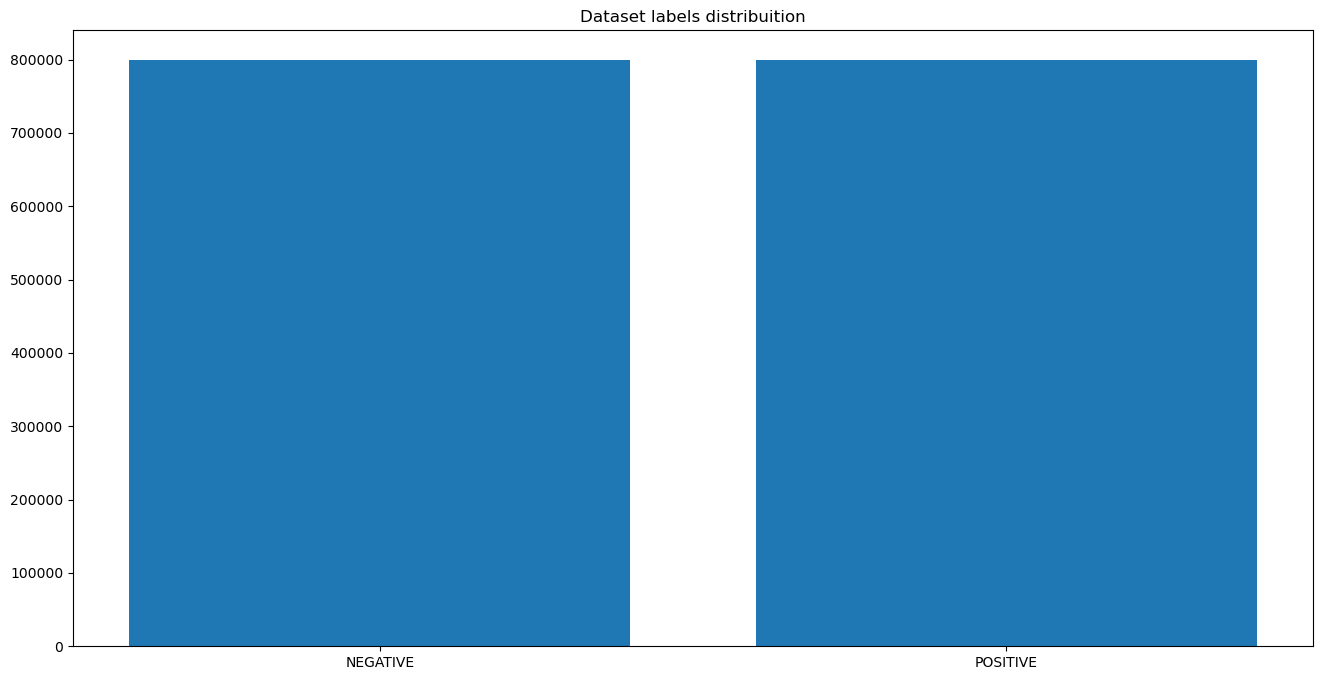

In [34]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

Text(0.5, 1.0, 'Dataset labels distribuition')

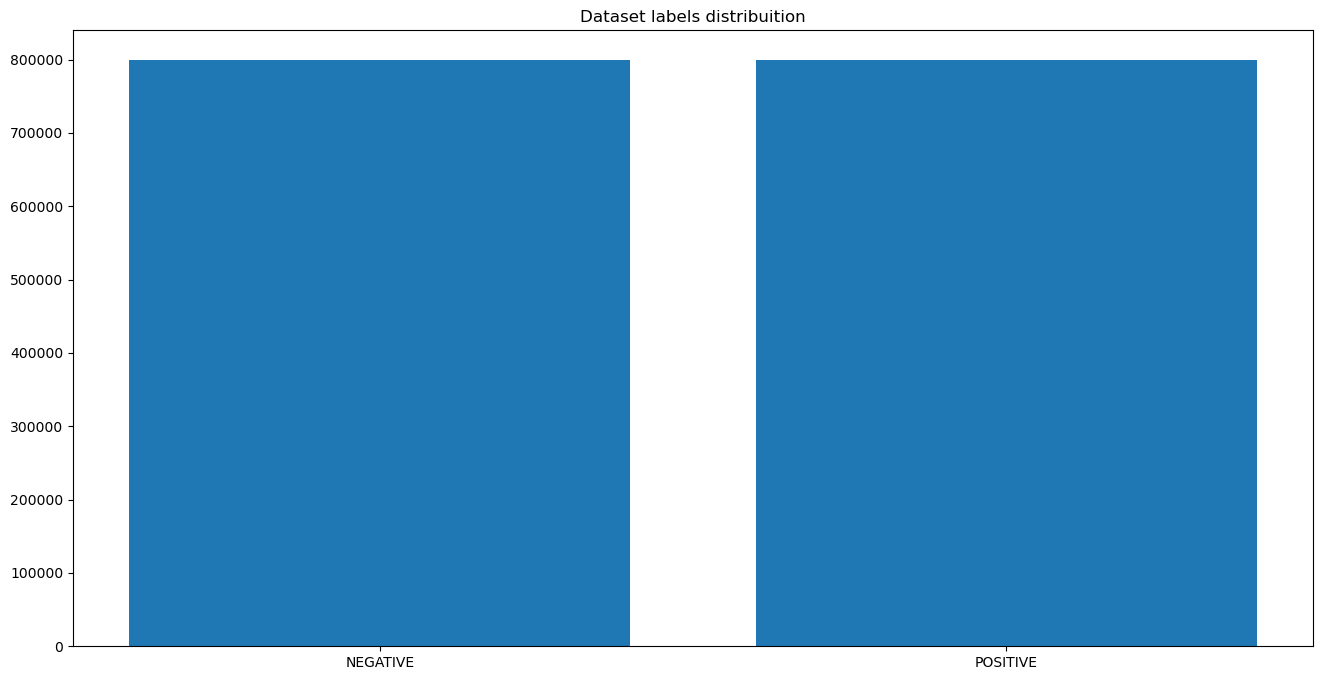

In [35]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [38]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [39]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [41]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: total: 25.1 s
Wall time: 37.3 s


In [42]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


In [43]:
%%time
documents = [_text.split() for _text in df_train.text]

CPU times: total: 1.39 s
Wall time: 3.51 s


In [66]:
w2v_model = gensim.models.Word2Vec(vector_size=W2V_SIZE, 
                                   window=W2V_WINDOW, 
                                   min_count=W2V_MIN_COUNT, 
                                   workers=8)


2024-04-11 17:51:44,138 : INFO : Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=300, alpha=0.025>', 'datetime': '2024-04-11T17:51:44.138249', 'gensim': '4.3.2', 'python': '3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22631-SP0', 'event': 'created'}


In [53]:
w2v_model.build_vocab(documents)

2024-04-11 17:38:16,179 : INFO : collecting all words and their counts
2024-04-11 17:38:16,181 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2024-04-11 17:38:16,227 : INFO : PROGRESS: at sentence #10000, processed 72565 words, keeping 14005 word types
2024-04-11 17:38:16,268 : INFO : PROGRESS: at sentence #20000, processed 144393 words, keeping 21587 word types
2024-04-11 17:38:16,293 : INFO : PROGRESS: at sentence #30000, processed 215826 words, keeping 27541 word types
2024-04-11 17:38:16,314 : INFO : PROGRESS: at sentence #40000, processed 288271 words, keeping 32764 word types
2024-04-11 17:38:16,339 : INFO : PROGRESS: at sentence #50000, processed 359772 words, keeping 37587 word types
2024-04-11 17:38:16,356 : INFO : PROGRESS: at sentence #60000, processed 431431 words, keeping 42198 word types
2024-04-11 17:38:16,381 : INFO : PROGRESS: at sentence #70000, processed 503103 words, keeping 46458 word types
2024-04-11 17:38:16,402 : INFO : PROGRESS: at s

2024-04-11 17:38:17,870 : INFO : PROGRESS: at sentence #720000, processed 5193881 words, keeping 200325 word types
2024-04-11 17:38:17,892 : INFO : PROGRESS: at sentence #730000, processed 5265467 words, keeping 202133 word types
2024-04-11 17:38:17,913 : INFO : PROGRESS: at sentence #740000, processed 5337518 words, keeping 203818 word types
2024-04-11 17:38:17,931 : INFO : PROGRESS: at sentence #750000, processed 5409321 words, keeping 205535 word types
2024-04-11 17:38:17,952 : INFO : PROGRESS: at sentence #760000, processed 5481512 words, keeping 207282 word types
2024-04-11 17:38:17,961 : INFO : PROGRESS: at sentence #770000, processed 5554093 words, keeping 209076 word types
2024-04-11 17:38:17,994 : INFO : PROGRESS: at sentence #780000, processed 5625382 words, keeping 210805 word types
2024-04-11 17:38:18,018 : INFO : PROGRESS: at sentence #790000, processed 5698066 words, keeping 212618 word types
2024-04-11 17:38:18,038 : INFO : PROGRESS: at sentence #800000, processed 577088

2024-04-11 17:38:19,736 : INFO : resetting layer weights
2024-04-11 17:38:19,737 : INFO : Word2Vec lifecycle event {'update': False, 'trim_rule': 'None', 'datetime': '2024-04-11T17:38:19.737729', 'gensim': '4.3.2', 'python': '3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22631-SP0', 'event': 'build_vocab'}


In [70]:
words = w2v_model.wv.key_to_index.keys()
vocab_size = len(words)
print("Vocab size:", vocab_size)


Vocab size: 0


In [72]:
 %%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)


RuntimeError: you must first build vocabulary before training the model

In [73]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419


In [74]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: total: 11.6 s
Wall time: 28.2 s


In [75]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [76]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [77]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [78]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

In [79]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [91]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix] ,trainable=False)

ValueError: Unrecognized keyword arguments passed to Embedding: {'weights': [array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])]}

In [82]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

NameError: name 'embedding_layer' is not defined

In [83]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [84]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [85]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8


ValueError: Sequential model sequential cannot be built because it has no layers. Call `model.add(layer)`.